In [10]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
from PIL import Image

def generate_procedural_landscape(size=256, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0, seed=0):
    """
    Generate a procedural landscape with hills and valleys using Perlin noise.
    
    :param size: The size of the landscape (size x size).
    :param scale: The scale of the noise.
    :param octaves: Number of layers of noise.
    :param persistence: Amplitude of each octave.
    :param lacunarity: Frequency of each octave.
    :param seed: The seed for generating different landscapes.
    :return: A 2D numpy array representing the landscape heights.
    """
    landscape = np.zeros((size, size))
    
    for i in range(size):
        for j in range(size):
            x = (i + seed) / scale
            y = (j + seed) / scale
            landscape[i][j] = pnoise2(x, y, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
    
    # Normalize the values to be between 0 and 1
    min_val = np.min(landscape)
    max_val = np.max(landscape)
    landscape = (landscape - min_val) / (max_val - min_val)
    
    return landscape

def lerp(color1, color2, t):
    """
    Linearly interpolate between two colors.
    
    :param color1: The first color (as an array of [R, G, B]).
    :param color2: The second color (as an array of [R, G, B]).
    :param t: The interpolation parameter (0 <= t <= 1).
    :return: The interpolated color.
    """
    return (1 - t) * np.array(color1) + t * np.array(color2)

def apply_colormap(landscape,
                   water_color=[0, 0, 255],
                   grass_color=[0, 255, 0],
                   mountain_color=[139, 69, 19],
                   snow_color=[255, 255, 255],
                   transition_width=0.05,
                   water_threshold=0.4,
                   grass_threshold=0.6,
                   mountain_threshold=0.8):
    """
    Apply a colormap to the landscape to simulate various elements (e.g., water, grass, mountains, snow) with soft edges.
    
    :param landscape: A 2D numpy array representing the landscape heights.
    :return: A 3D numpy array with RGB values.
    """
    
    # Create an RGB image
    rgb_image = np.zeros((landscape.shape[0], landscape.shape[1], 3), dtype=np.uint8)
    
    # Apply colors based on thresholds with gradients
    for i in range(landscape.shape[0]):
        for j in range(landscape.shape[1]):
            height = landscape[i, j]
            
            if height < water_threshold - transition_width:
                rgb_image[i, j] = water_color
            elif height < water_threshold + transition_width:
                t = (height - (water_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(water_color, grass_color, t)
            elif height < grass_threshold - transition_width:
                rgb_image[i, j] = grass_color
            elif height < grass_threshold + transition_width:
                t = (height - (grass_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(grass_color, mountain_color, t)
            elif height < mountain_threshold - transition_width:
                rgb_image[i, j] = mountain_color
            elif height < mountain_threshold + transition_width:
                t = (height - (mountain_threshold - transition_width)) / (2 * transition_width)
                rgb_image[i, j] = lerp(mountain_color, snow_color, t)
            else:
                rgb_image[i, j] = snow_color
    
    return rgb_image

def landscape_as_image(landscape, colormaped=True):
    """
    Save the procedural landscape as a colorful image file.
    
    :param landscape: A 2D numpy array representing the landscape heights.
    :param filename: The filename to save the image as.
    """
    if colormaped:
        # Apply the colormap
        rgb_image = apply_colormap(landscape, transition_width=0.1)
    else:
        # Normalize the values to be between 0 and 255
        rgb_image = (landscape * 255).astype(np.uint8)
        rgb_image = np.stack([rgb_image] * 3, axis=-1)
    
    # Create an image object
    image = Image.fromarray(rgb_image, mode='RGB')
    
    return image


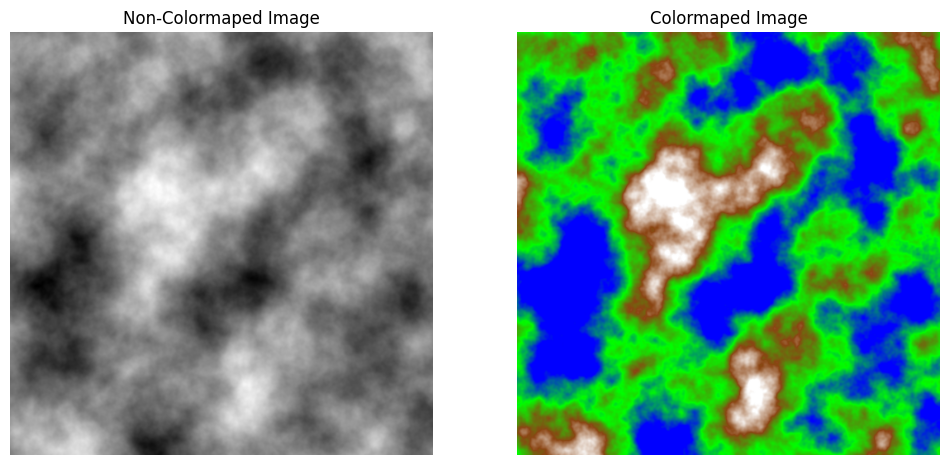

In [11]:
landscape = generate_procedural_landscape(size=512, scale=128)

non_colormaped_image = landscape_as_image(landscape, colormaped=False)

image = landscape_as_image(landscape)

# Show non-colormaped image and colormaped image side by side
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(non_colormaped_image)
plt.axis('off')
plt.title('Non-Colormaped Image')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.axis('off')
plt.title('Colormaped Image')
plt.show()

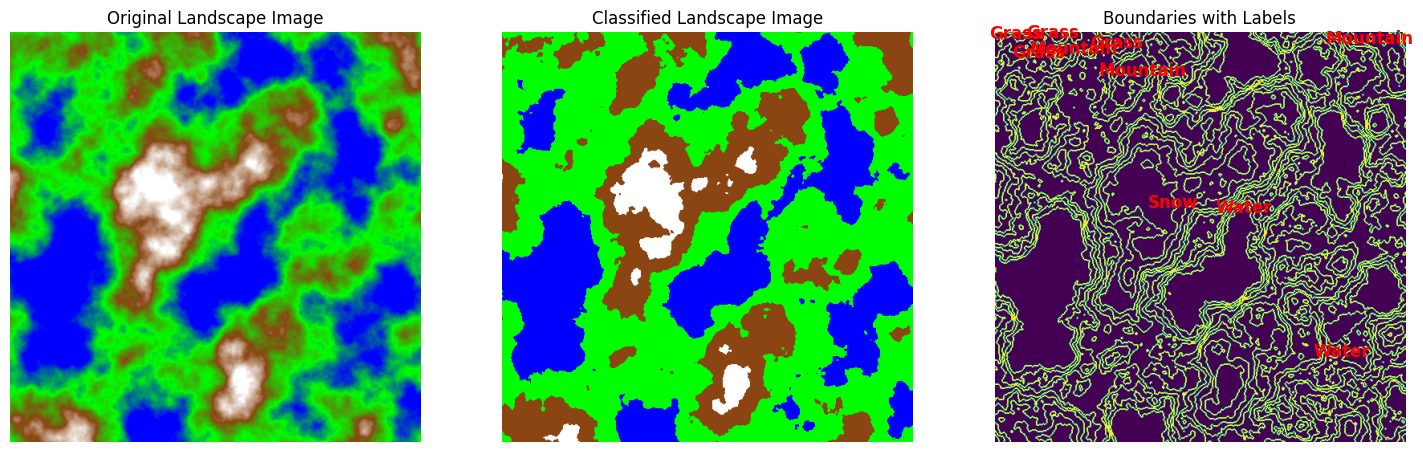

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from skimage.segmentation import find_boundaries
from skimage.color import label2rgb
from skimage.measure import regionprops, label

def classify_image(image, n_clusters=10):
    """
    Classify the image into regions using K-means clustering.
    
    :param image_np: A numpy array representing the image.
    :param n_clusters: The number of clusters to classify into.
    :return: A 2D numpy array with cluster labels and the cluster centers.
    """
    # Convert the image to a numpy array
    image_np = np.array(image)

    # Reshape the image to a list of pixels
    pixels = image_np.reshape(-1, 3)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    
    # Get the cluster labels and centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    # Reshape the labels back to the original image shape
    classified_image = labels.reshape(image_np.shape[:2])
    
    return classified_image, centers

def apply_cluster_colormap(classified_image, centers):
    """
    Apply a colormap to the classified image.
    
    :param classified_image: A 2D numpy array with cluster labels.
    :param centers: The cluster centers.
    :return: A 3D numpy array with RGB values.
    """
    # Define target colors for each landscape element
    target_colors = np.array([
        [0, 0, 255],       # Blue for water
        [0, 255, 0],       # Green for grass
        [139, 69, 19],     # Brown for mountains
        [255, 255, 255]    # White for snow
    ])
    
    # Match the cluster centers to the target colors
    distances = cdist(centers, target_colors)
    closest_colors = np.argmin(distances, axis=1)
    
    # Create an RGB image
    rgb_image = np.zeros((classified_image.shape[0], classified_image.shape[1], 3), dtype=np.uint8)
    
    for cluster_label in range(len(centers)):
        rgb_image[classified_image == cluster_label] = target_colors[closest_colors[cluster_label]]
    
    return rgb_image, closest_colors

def find_image_boundaries(classified_image, closest_colors):
    """
    Find the boundaries of classified regions in the image and label them.
    
    :param classified_image: A 2D numpy array with cluster labels.
    :param closest_colors: The mapped color labels for each cluster.
    :return: A 2D numpy array with boundaries.
    """
    boundaries = find_boundaries(classified_image, mode='thick')
    return boundaries

# Classify the image using K-means clustering
classified_image, centers = classify_image(image, n_clusters=10)

# Apply the colormap to the classified image
rgb_image, closest_colors = apply_cluster_colormap(classified_image, centers)

# Find the boundaries in the classified image and add labels
boundaries_image = find_image_boundaries(classified_image, closest_colors)

# Define labels for each landscape element
labels_dict = {
    0: 'Water',
    1: 'Grass',
    2: 'Mountain',
    3: 'Snow'
}

# Display the original, classified, and boundaries images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image)
ax[0].set_title('Original Landscape Image')
ax[0].axis('off')

ax[1].imshow(rgb_image)
ax[1].set_title('Classified Landscape Image')
ax[1].axis('off')

ax[2].imshow(boundaries_image)
ax[2].set_title('Boundaries with Labels')

# Use regionprops to find centroids of each region and add one label per class
labeled_array, num_features = label(classified_image, return_num=True)
props = regionprops(labeled_array)

labeled_classes = set()

for prop in props:
    y, x = prop.centroid
    label_index = classified_image[int(y), int(x)]
    if label_index not in labeled_classes:
        label_text = labels_dict.get(closest_colors[label_index], 'Unknown')
        ax[2].text(x, y, label_text, color='red', fontsize=12, ha='center', va='center', weight='bold')
        labeled_classes.add(label_index)

ax[2].axis('off')

plt.show()


In [14]:
# Load .data/alps.png into an image object
image = Image.open('.data/alps.png')

# Classify the image using K-means clustering
classified_image, centers = classify_image(image, n_clusters=10)

# Apply the colormap to the classified image
rgb_image, closest_colors = apply_cluster_colormap(classified_image, centers)

# Find the boundaries in the classified image and add labels
boundaries_image = find_image_boundaries(classified_image, closest_colors)

# Display the original, classified, and boundaries images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image)
ax[0].set_title('Original Landscape Image')
ax[0].axis('off')

ax[1].imshow(rgb_image)
ax[1].set_title('Classified Landscape Image')
ax[1].axis('off')

ax[2].imshow(boundaries_image)
ax[2].set_title('Boundaries with Labels')

# Use regionprops to find centroids of each region and add one label per class
labeled_array, num_features = label(classified_image, return_num=True)
props = regionprops(labeled_array)

labeled_classes = set()

for prop in props:
    y, x = prop.centroid
    label_index = classified_image[int(y), int(x)]
    if label_index not in labeled_classes:
        label_text = labels_dict.get(closest_colors[label_index], 'Unknown')
        ax[2].text(x, y, label_text, color='red', fontsize=12, ha='center', va='center', weight='bold')
        labeled_classes.add(label_index)

ax[2].axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '.data/alps.png'